In [19]:
# Packages
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
df = pd.read_csv("../Data/modeling.csv")

In [21]:
X = df.set_index("Geography")
y = X.pop("311_index_per_property")

In [22]:
list(X)

['his_num_311_per_property',
 'neighbor_his_num_per_property',
 'snow_depth',
 'percent_below_poverty',
 'percent_civilian_unemployed',
 'per_capita_income',
 'percent_no_highschool',
 'percent_65older',
 'percent_17younger',
 'percent_household_disability',
 'percent_single_parent_household',
 'percent_minority',
 'percent_notwell_english',
 'percent_singleunits',
 'percent_multiunit',
 'percent_mobile_homes',
 'percent_owneroccupiedunit',
 'percent_crowding',
 'percent_group_quarters',
 'median_year_properties_built',
 'median_value_properties_built',
 'percent_no_vehicle']

In [23]:
y

Geography
360290001101    10.697674
360290001102     6.458797
360290001103    11.065574
360290002001     7.777778
360290002002    11.986301
                  ...    
360290171001     8.139535
360290171002    13.537118
360290171003     9.836066
360290171004     5.882353
360290171005     8.620690
Name: 311_index_per_property, Length: 286, dtype: float64

<Axes: >

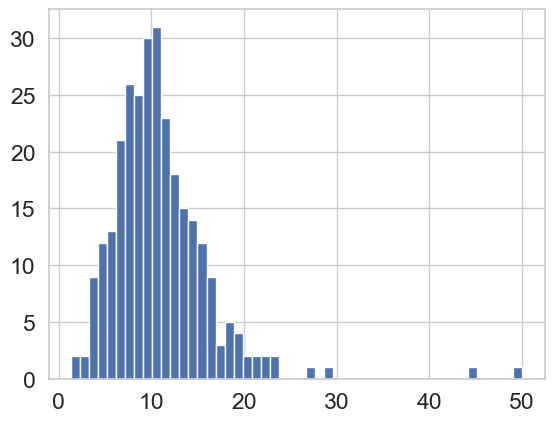

In [24]:
y.hist(bins=50)

In [25]:
len(X),len(X.columns), len(y)

(286, 22, 286)

In [26]:
# feature importance table
df_feaimp = pd.DataFrame({'feature':X.columns}).set_index('feature')

In [27]:
def standarize_data(data, stats):
    return (data - stats['mean'])/ stats['std']

In [28]:
y_rf_predict = []
y_true = []

ten_fold = KFold(n_splits=10, shuffle=True, random_state=42)

fold_index = 0

avg_r_squared = 0

for train_index, test_index in ten_fold.split(X):
    print("TEST:", test_index)
    fold_index += 1

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    training_stat = X_train.describe().transpose()
    scaled_X_train = standarize_data(X_train, training_stat)
    scaled_X_test = standarize_data(X_test, training_stat)
    
    rf = RandomForestRegressor(bootstrap=True, max_depth = 20, n_estimators=20, max_features=22, random_state=42) # input

    rf.fit(scaled_X_train, y_train)
    
    y_train_pred = rf.predict(scaled_X_train).flatten()
    r2_train = r2_score(y_train, y_train_pred)
    # print(r2_train)
    
    ## record feature importance
    df_feaimp['fold_'+str(fold_index)] = rf.feature_importances_
    ## finish recording feature importance

    this_y_predict = rf.predict(scaled_X_test).flatten()

    y_rf_predict = y_rf_predict + this_y_predict.tolist()
    y_true = y_true + y_test.tolist()
    print(r2_score(y_test, this_y_predict))
    avg_r_squared += r2_score(y_test, this_y_predict)

TEST: [  5   9  33  45  56  73  79 109 111 124 143 146 155 170 185 196 200 212
 217 220 227 233 251 265 267 268 274 275 283]
0.3765040292796631
TEST: [  6  22  24  30  42  46  60  63  75  77  84  92  93 116 147 164 175 177
 181 193 203 204 207 211 221 234 240 249 269]
0.05370290258932109
TEST: [ 10  15  16  18  19  25  37  66  67  68  82  86  90 112 113 117 120 125
 139 144 154 159 165 202 219 246 250 255 258]
0.3810771657008548
TEST: [  2  31  38  55  57  69  78  97 101 104 108 114 119 126 132 148 152 167
 173 184 206 218 224 232 254 264 272 277 281]
0.15469300088018867
TEST: [ 12  29  35  65  74  76  85  96 107 115 118 127 137 140 157 158 168 172
 176 179 183 192 194 216 223 238 239 278 284]
0.2545825895383328
TEST: [  0  11  26  28  36  41  51  61  95  98 100 136 141 142 150 178 180 186
 195 210 215 225 226 231 242 256 263 266 279]
0.6221893165724421
TEST: [  4  23  27  32  40  44  62  64  70 122 123 128 135 138 153 156 162 182
 197 208 209 229 236 247 253 271 276 282]
0.22815660172

In [29]:
rf_rmse = mean_squared_error(y_true , y_rf_predict, squared=False)
rf_r2 = r2_score(y_true, y_rf_predict)
avg_r_squared = avg_r_squared/10

C:\Users\ryanz\anaconda3\envs\blizzard\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [30]:
print("RMSE: "+str(rf_rmse))
print("R2: "+str(rf_r2))

RMSE: 4.04193815658491
R2: 0.4229680451880239


1.36986301369863
50.0
4.683877313544706
29.985481149019694


<Figure size 1000x800 with 0 Axes>

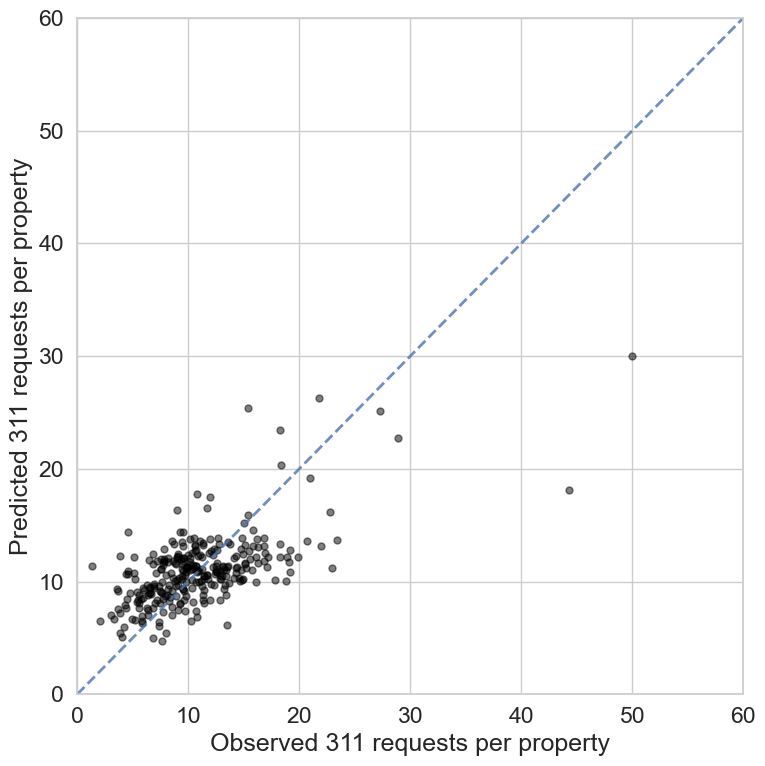

In [31]:
# Scatter-curve plot
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 28}

matplotlib.rc('font', **font)

plt.figure(figsize=(10,8))
sns.set_theme(style="whitegrid",font_scale = 1.5)

def prediction_scatter(true_label, prediction, lims, title):
    plt.figure(figsize=(8,8))
    scatter = plt.plot(true_label, prediction, "o", markersize=5, alpha=0.5, color="black")
    line = plt.plot(lims, lims, "b--",alpha=0.8, linewidth=2)
    plt.xlim(lims)
    plt.ylim(lims)
    plt.xlabel('Observed 311 requests per property')
    plt.ylabel('Predicted 311 requests per property')
    plt.title(title)
    
print(np.min(y_true))
print(np.max(y_true))
print(np.min(y_rf_predict))
print(np.max(y_rf_predict))

#scatter plot
lims = [0, 60]
prediction_scatter(y_true, y_rf_predict, lims, "")
plt.tight_layout()